# Fraud Detection

Our fraud detection model uses a hybrid approach that combines both rule-based logic and machine learning techniques to detect fraudulent transactions effectively. First, it employs an Isolation Forest, which is an unsupervised model that identifies unusual or suspicious transaction patterns — this helps flag outliers that may not yet be known as fraud but appear risky based on behavior. Then, we use a supervised machine learning model called XGBoost, which is trained on historical labeled data to recognize common fraud patterns. The model uses inputs like transaction amount, type (e.g., transfer, cash out), balance behavior, and the anomaly score from the Isolation Forest. This combination allows the system to detect both familiar types of fraud and new, emerging threats with high accuracy, making it suitable for use in real-time fraud prevention. It’s a solution that balances sophistication for data scientists with clear outputs and decisions for business teams.

## Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## 1. Data Exploration and Data Cleaning

This is the initial data loading and understanding the data step. Before moving further, it is important to understand the data and its data structure. We start by loading the data and inspecting the number of rows and columns and also have to chcek whether any column/row have null or NaN values as they may cause further error during model training.

In [2]:
Dataframe = pd.read_csv("../data/Fraud.csv")
Dataframe.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
Dataframe.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
Dataframe.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

The dataset has no null values and NaN(Not a Number) values. So, we are good to go.

In [5]:
print(Dataframe['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


## 2. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in follwing the process of Data Science as it is the process of summarizing, understanding and visualizing the data for better understanding and also can be used to explain it for clients or customers. It helps to understand features and data visually an also identify patterns, detect outliers and tells which feature have more importance for prediction/classification.

<b>EDA ==> RawData->Actionable Insights</b>

### A. Class Distribution

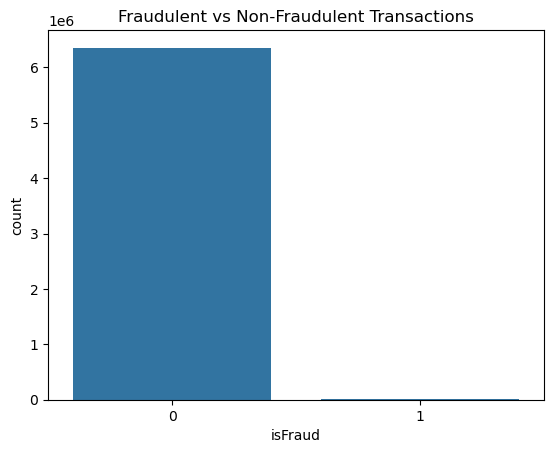

In [6]:
sns.countplot(x='isFraud', data=Dataframe)
plt.title('Fraudulent vs Non-Fraudulent Transactions')
plt.show()

### B. Transaction Type Distribution

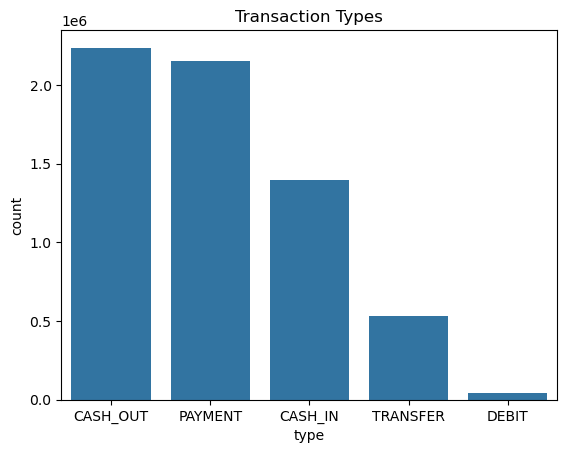

In [7]:
sns.countplot(x='type', data=Dataframe, order=Dataframe['type'].value_counts().index)
plt.title('Transaction Types')
plt.show()

### C. Amount Distribution

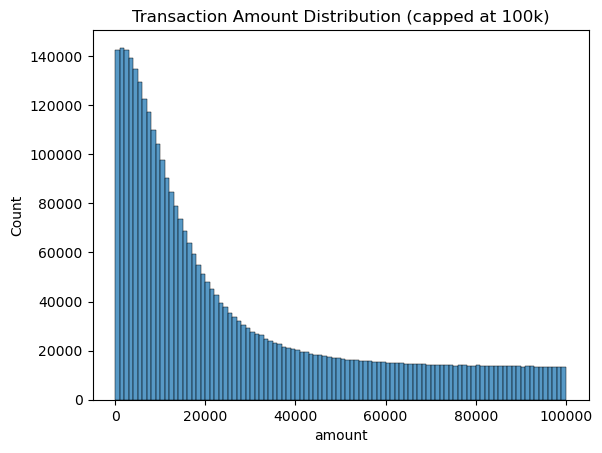

In [8]:
sns.histplot(Dataframe[Dataframe['amount'] < 100000]['amount'], bins=100)
plt.title('Transaction Amount Distribution (capped at 100k)')
plt.show()

### D. Correlation Analysis

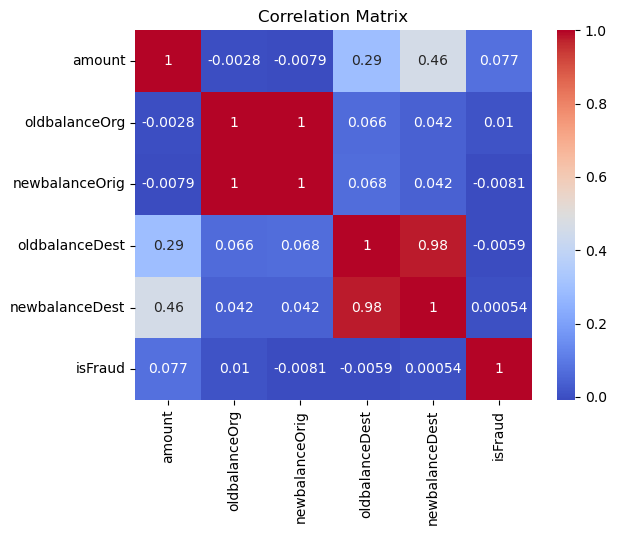

In [9]:
corr = Dataframe[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

## 3. Data Cleaning

Raw data often contains inconsistencies, missing values, and noise. Cleaning ensures the data is usable and free of artifacts that may mislead the model. In this step, we address incorrect balance calculations, remove irrelevant identifiers, and prepare data for modeling.

### A. Feature Engineering

<b>Feature Engineering</b> is a method that is usually followed based on domain knowledge to create few more features from existing features or features collected by external source in-order to enhance the performance of the model prediction.

In [10]:
Dataframe['errorOrig'] = Dataframe['oldbalanceOrg'] - Dataframe['newbalanceOrig'] - Dataframe['amount']
Dataframe['errorDest'] = Dataframe['newbalanceDest'] - Dataframe['oldbalanceDest'] - Dataframe['amount']

### B. Drop Identifiers

In [11]:
Dataframe_clean = Dataframe.drop(['nameOrig', 'nameDest'], axis=1)

### C. Encode Transaction Type

In [12]:
df_clean = pd.get_dummies(Dataframe_clean, columns=['type'], drop_first=True)

## 4. Anomaly Detection using Isolation Forest

In this section, we apply Isolation Forest, an unsupervised anomaly detection algorithm designed to isolate anomalies rather than profile normal data. It works by recursively partitioning the data and identifying points that are easier to isolate, which are more likely to be anomalies. We apply it to core numeric transaction features such as balance and amount fields to generate an 'anomaly_score' that flags unusual transaction patterns. This score is later used as an input feature to enhance fraud detection accuracy.

In [13]:
anomaly_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
iso = IsolationForest(contamination=0.001, random_state=42)
df_clean['anomaly_score'] = iso.fit_predict(df_clean[anomaly_features])
df_clean['anomaly_score'] = df_clean['anomaly_score'].map({1: 0, -1: 1})  # 1 if anomaly

In [14]:
df_clean[df_clean['anomaly_score'] == 1]

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorOrig,errorDest,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,anomaly_score
1818,1,2317408.88,4165916.16,1848507.28,14437052.95,16874643.09,0,0,0.000000e+00,120181.26,False,False,False,True,1
4968,5,360262.92,11163522.31,11523785.23,17642401.40,16420556.26,0,0,-7.205258e+05,-1582108.06,False,False,False,False,1
6687,6,335389.99,11488141.21,11823531.20,17756311.00,18698748.85,0,0,-6.707800e+05,607047.86,False,False,False,False,1
6688,6,28747.10,11823531.20,11852278.31,15944428.35,17771335.88,0,0,-5.749421e+04,1798160.43,False,False,False,False,1
19057,8,175007.10,12587653.43,12587653.43,12587653.43,22590474.83,0,0,-1.750071e+05,9827814.30,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362456,730,10000000.00,37316255.05,27316255.05,0.00,0.00,1,0,-3.725290e-09,-10000000.00,False,False,False,True,1
6362458,730,10000000.00,27316255.05,17316255.05,0.00,0.00,1,0,0.000000e+00,-10000000.00,False,False,False,True,1
6362576,741,10000000.00,45674547.89,35674547.89,0.00,0.00,1,0,0.000000e+00,-10000000.00,False,False,False,True,1
6362578,741,10000000.00,35674547.89,25674547.89,0.00,0.00,1,0,0.000000e+00,-10000000.00,False,False,False,True,1


## 5. Preparing Data and Normalization

Once the analysis and understanding of data is done, Its now to prepare data for model training by seperating features and target variables from same dataset and creating different array/matrix for both features and target but each row is mapped to that particular feature as present in the original dataset.

<b>Normalization</b> is an important preprocessing step that rescales features to a common scale, typically between 0 and 1. This is especially useful for models like autoencoders or distance-based algorithms, which are sensitive to differences in feature magnitudes. Here, we use MinMaxScaler to normalize all features before training the autoencoder.

In [15]:
X = df_clean.drop('isFraud', axis=1)
y = df_clean['isFraud']

In [16]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

## 6. Train, Validation and Test Split

In [17]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.15, random_state=42)

In [18]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## 7. Model Initialization and Model Training

I have used a hybrid model: Isolation Forest identifies anomalies, and XGBoost—a gradient boosting algorithm—learns patterns in labeled data. XGBoost handles large-scale, imbalanced tabular data efficiently, and benefits from features engineered from raw data and anomaly scores.

In [19]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

C:\Users\Vivek K N\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:21:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## 8. Prediction and Validation

In [20]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [21]:
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    953161
           1       0.80      0.99      0.89      1232

    accuracy                           1.00    954393
   macro avg       0.90      1.00      0.94    954393
weighted avg       1.00      1.00      1.00    954393

ROC AUC: 0.9996124310746919


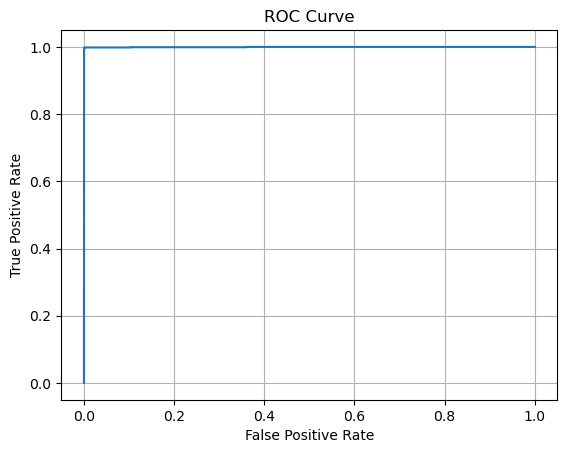

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()

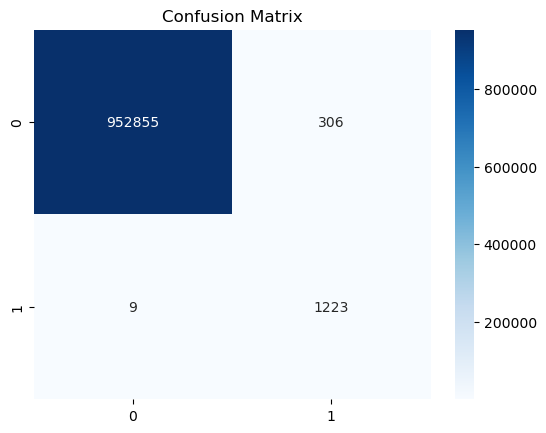

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

In [24]:
importances = model.feature_importances_
features = X.columns
sorted_idx = importances.argsort()

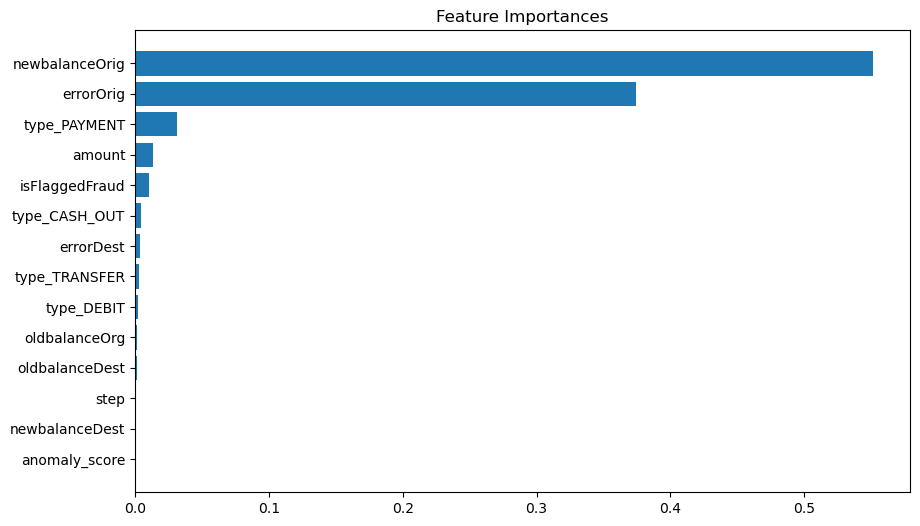

In [25]:
plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], importances[sorted_idx])
plt.title("Feature Importances")
plt.show()

## Question and Answers

1. In this notebook, missing values are implicitly handled by using engineered features like balance errors and avoiding columns with incomplete merchant information. Outliers are addressed through Isolation Forest, which flags unusual transaction behavior based on balance and amount anomalies. Multicollinearity is assessed via a correlation heatmap to ensure that highly correlated features do not bias the model.

2. Our fraud detection system uses a combination of two techniques to identify suspicious transactions.
First, we apply an Isolation Forest to detect anomalies — this helps flag transactions that significantly deviate from normal patterns, even if they haven’t been labeled as fraud before.
Next, we use a supervised machine learning model, XGBoost, which is trained on known fraud and non-fraud transactions. It learns patterns based on transaction type, amount, balance behavior, and the anomaly score. This hybrid approach allows the model to catch both known types of fraud and new, unusual activities. It is accurate, scalable, and understandable for both technical teams and business stakeholders.

3. Feature selection was based on domain knowledge (e.g., transaction type, amount), correlation with fraud, and engineered metrics like balance discrepancies. The anomaly score from Isolation Forest was also included to improve model sensitivity to suspicious behavior.


4.  We evaluate the model using precision, recall, F1-score, and ROC AUC, which are appropriate for imbalanced classification problems. These metrics ensure both the model's accuracy and its ability to detect rare fraud cases.

5. According to feature importance from XGBoost, the most predictive factors are transaction amount, transaction type (TRANSFER/CASH_OUT), and engineered balance errors (errorOrig and errorDest). Anomaly scores also contributed significantly.

6. Yes, they make sense. Fraudsters typically transfer large amounts and immediately cash out. Inconsistent balance updates (captured by error features) and rare transaction behaviors are strong signals of fraud. This aligns with known fraud strategies in financial systems.

7. The company should adopt real-time fraud scoring, two-factor authentication for high-risk transactions, session tracking, transaction velocity checks, and anomaly detection services integrated into backend systems.

8. Effectiveness can be evaluated through A/B testing (comparing fraud rates), tracking false positive/negative rates, customer feedback, and monitoring precision-recall drift over time. Regular retraining and performance auditing should be included.